In [1]:
import duckboat as uck
import pandas as pd
import seaborn as sns

In [2]:
t = uck.Database(
    old = uck.Table('old.csv'),
    final = uck.Table('final.csv'),
    fallback = uck.Table('fallback.csv'),
).do(
    """
    select *, 'old' as algo from old
    union all
    select *, 'final' as algo from final
    union all
    select *, 'fallback' as algo from fallback
    """
)
t

┌───────────────┬──────────────┬──────────┐
│     name      │ microseconds │   algo   │
│    varchar    │    double    │ varchar  │
├───────────────┼──────────────┼──────────┤
│ 2_8           │       979.43 │ old      │
│ 8_14          │     1354.988 │ old      │
│ 8_14_null_2   │      748.978 │ old      │
│ 8_14_null_10  │     1234.543 │ old      │
│ 8_14_null_100 │     1317.698 │ old      │
│ 2_8           │     1003.892 │ old      │
│ 8_14          │     1349.913 │ old      │
│ 8_14_null_2   │      746.612 │ old      │
│ 8_14_null_10  │     1233.247 │ old      │
│ 8_14_null_100 │     1317.503 │ old      │
│  ·            │         ·    │  ·       │
│  ·            │         ·    │  ·       │
│  ·            │         ·    │  ·       │
│ 2_8           │      403.196 │ fallback │
│ 8_14          │      845.458 │ fallback │
│ 8_14_null_2   │      495.243 │ fallback │
│ 8_14_null_10  │       809.72 │ fallback │
│ 8_14_null_100 │       841.95 │ fallback │
│ 2_8           │      391.509 │

In [3]:
df = t.do(
    "where name = '8_14_null_100'",
    # """
    # select
    #     algo,
    #     min(microseconds),
    # group by
    #     1
    # """
    'pandas'
)

In [4]:
df

,name,microseconds,algo
0,8_14_null_100,1317.698,old
1,8_14_null_100,1317.503,old
2,8_14_null_100,1406.140,old
3,8_14_null_100,1352.988,old
4,8_14_null_100,1321.513,old
...,...,...,...
613,8_14_null_100,841.822,fallback
614,8_14_null_100,842.119,fallback
615,8_14_null_100,842.287,fallback
616,8_14_null_100,841.950,fallback


<Axes: xlabel='microseconds', ylabel='Density'>

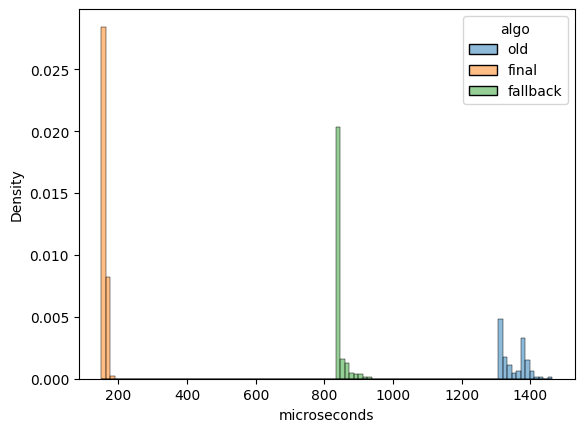

In [5]:
sns.histplot(df, x='microseconds', hue='algo', bins=100, multiple='layer', stat="density")

In [19]:
t.do(
    """
    select
        name,
        algo,
        min(microseconds)
            as mus,
    group by
        1,2
    """,
    'alias t',
    """
    select
        name
        , t1.algo
            as algo1
        , t2.algo
            as algo2
        , round(t1.mus / t2.mus, 1)
            as speedup
    from
        t as t1
    left join
        t as t2
    using
        (name)
    """,
    "where algo2 = 'final' ",
    "where algo1 = 'old' ",
    'order by 1,2',
)

┌───────────────┬─────────┬─────────┬─────────┐
│     name      │  algo1  │  algo2  │ speedup │
│    varchar    │ varchar │ varchar │ double  │
├───────────────┼─────────┼─────────┼─────────┤
│ 2_8           │ old     │ final   │     6.4 │
│ 8_14          │ old     │ final   │     9.1 │
│ 8_14_null_10  │ old     │ final   │     7.8 │
│ 8_14_null_100 │ old     │ final   │     8.8 │
│ 8_14_null_2   │ old     │ final   │     5.0 │
└───────────────┴─────────┴─────────┴─────────┘